In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from data_handlers.network import parse_bwms
from data_handlers.procmem import parse_pidstat

In [13]:
experiment_path = pathlib.Path(f"/home/jovyan/work/binary_files/137/")
color_mapping = {
    'epidemic': 'C0',
    'context_complex': 'C1',
}

In [14]:
network_df = parse_bwms(experiment_path)

In [15]:
procmem_df = parse_pidstat(experiment_path)

In [16]:
merged = procmem_df.merge(network_df, left_index=True, right_index=True).reset_index()

In [17]:
cleared = merged
cleared['%CPU'] = (cleared['%CPU'] - cleared['%CPU'].min()) / (cleared['%CPU'].max() - cleared['%CPU'].min())
cleared.loc[cleared['routing'] == 'epidemic', 'routing'] = 'Epidemic'
cleared.loc[cleared['routing'] == 'context_complex', 'routing'] = 'Softwarere Defined\nComplex'

Starting Epidemic
Plotting bandwidth for Epidemic
Plotting CPU for Epidemic


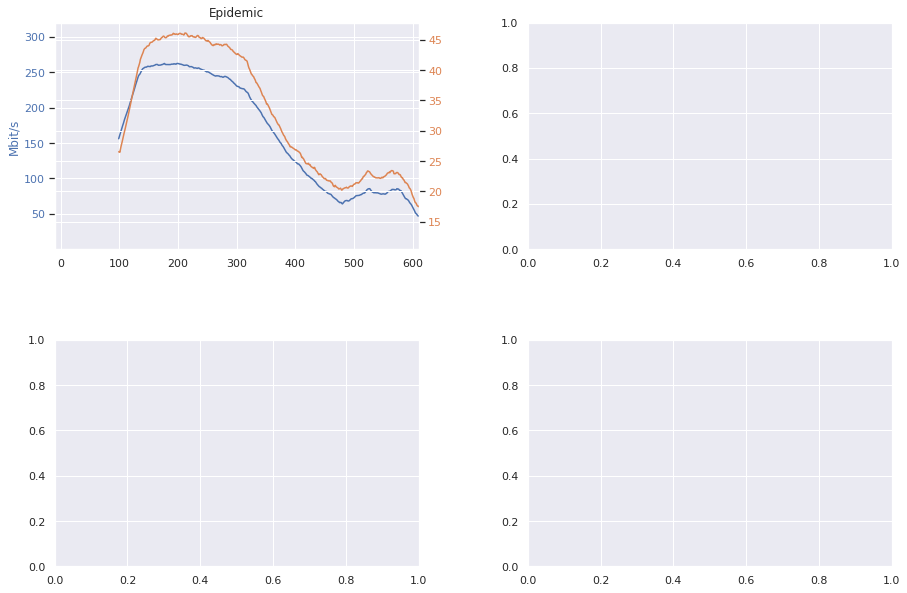

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=.3, hspace=.4)

fig.set_size_inches(15,10)

color_mbit = 'C0'
color_cpu = 'C1'

for ax, (name, routing_df) in zip(list(axs[0]) + list(axs[1]), cleared.groupby(['routing'])):
    print(f"Starting {name}")
    ax.tick_params(axis='y', labelcolor=color_mbit)
    ax.set_xlim(-10, 610)
    ax.set_ylim(0.01, 320)
    
    ax.set_title(name)
    
    ax2 = ax.twinx()
    ax2.tick_params(axis='y', labelcolor=color_cpu)
    ax.ticklabel_format(style='plain', axis='y')
    ax2.ticklabel_format(style='plain', axis='y')
                    
    routing_df = routing_df.reset_index()

    print(f"Plotting bandwidth for {name}")
    sns.lineplot(
        x=routing_df['dt'],
        y=routing_df['Mbit/s'].rolling(100).mean(),
        ax=ax,
        color=color_mbit
    )

    print(f"Plotting CPU for {name}")
    sns.lineplot(
        x=routing_df['dt'],
        y=routing_df['%CPU'].rolling(100).sum(),
        ax=ax2,
        color=color_cpu
    )

    if ax.figbox.x0 == 0.125: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_ylabel('Mbit/s', color=color_mbit)
        ax2.set_ylabel('')
    if ax.figbox.x0 == 0.5630434782608696: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_ylabel('', color=color_mbit)
        ax2.set_ylabel('%CPU', color=color_cpu)

    if ax.figbox.y0 == 0.125: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_xlabel('Time (s)')
    if ax.figbox.y0 == 0.5654166666666667: #Just some magic number. You can find it with print(ax.figbox)
        ax.set_xlabel('')
        
    ttl = ax.title
    ttl.set_position([.5, 1.05])
                        
plt.savefig('cpu_network.pdf')

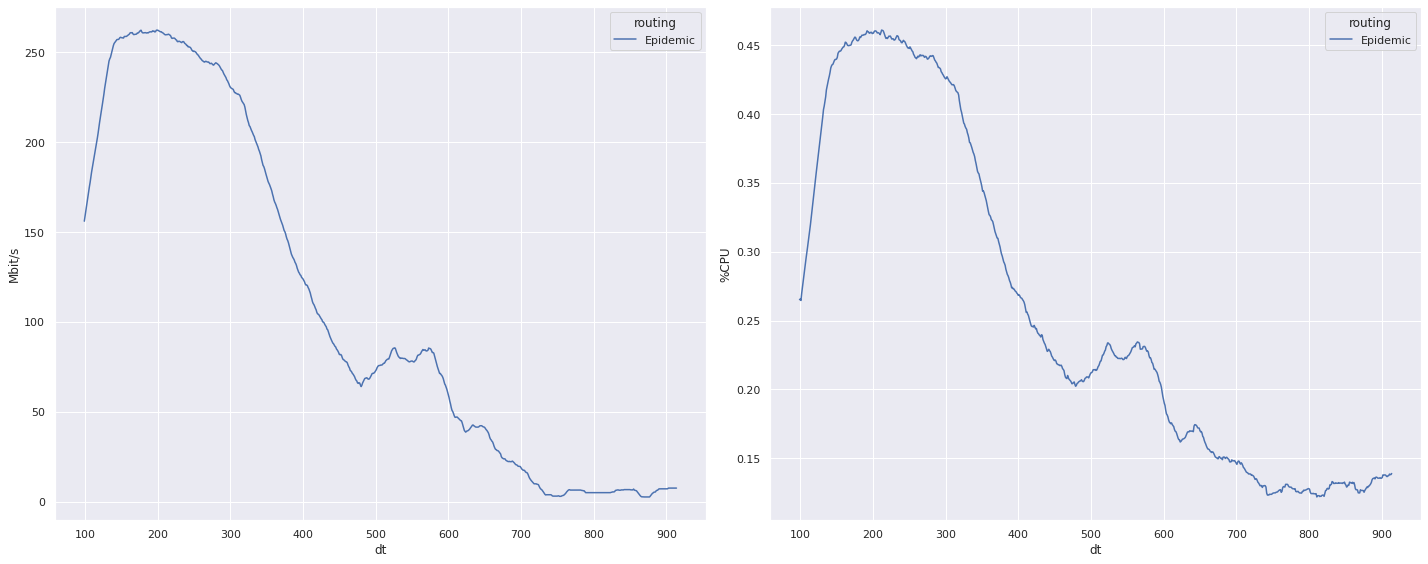

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(
    x=cleared["dt"],
    y=cleared['Mbit/s'].rolling(100).mean(),
    hue=cleared["routing"],
    ax=axs[0]
)

sns.lineplot(
    x=cleared["dt"],
    y=cleared['%CPU'].rolling(100).mean(),
    hue=cleared["routing"],
    ax=axs[1]
)

fig.tight_layout()

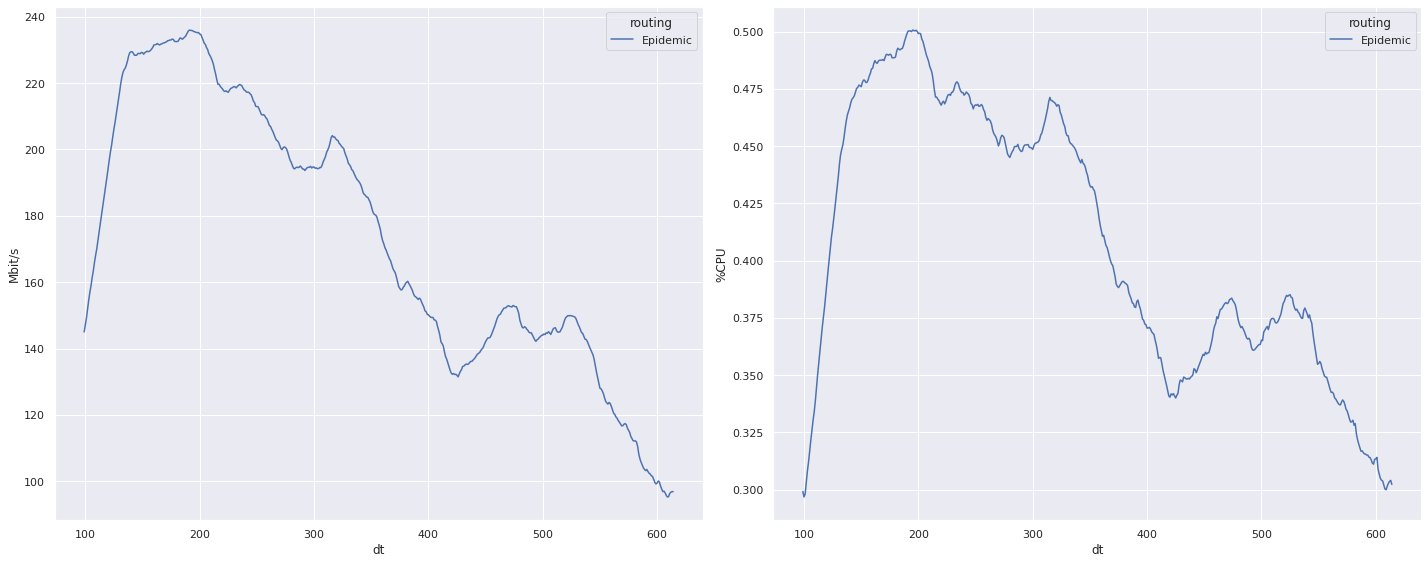

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(
    x=cleared["dt"],
    y=cleared['Mbit/s'].rolling(100).mean(),
    hue=cleared["routing"],
    ax=axs[0],
    ci=None
)

sns.lineplot(
    x=cleared["dt"],
    y=cleared['%CPU'].rolling(100).mean(),
    hue=cleared["routing"],
    ax=axs[1],
    ci=None
)

fig.tight_layout()